# Using Python With Quandl Data

### Preliminaries

We want plots to appear in this notebook rather than in a separate window.

In [8]:
%matplotlib inline

Import Python modules to support our research.  If you are using _Anaconda_ then you may need to run _conda install seaborn_ and similar commands.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Load the Data


We are likely to run this notebook over and over, so we add memoizaiton to the data loading function. This makes testing and re-running our code far faster, and even lets us work offline.  Note that if we change the code inside our function, we may get unexpectedly stale results out of the cache!

In [2]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    print("Fetching from Quandl")
    qdata = quandl.get(list(my_securities), returns="pandas")
    return qdata

In [3]:
raw_data = fetch_quandl(('WIKI/XOM', "NSE/OIL"))


Fetching from Quandl


### See what we downloaded

In [4]:
raw_data.tail()

,WIKI/XOM - Open,WIKI/XOM - High,WIKI/XOM - Low,WIKI/XOM - Close,WIKI/XOM - Volume,WIKI/XOM - Ex-Dividend,WIKI/XOM - Split Ratio,WIKI/XOM - Adj. Open,WIKI/XOM - Adj. High,WIKI/XOM - Adj. Low,WIKI/XOM - Adj. Close,WIKI/XOM - Adj. Volume,NSE/OIL - Open,NSE/OIL - High,NSE/OIL - Low,NSE/OIL - Last,NSE/OIL - Close,NSE/OIL - Total Trade Quantity,NSE/OIL - Turnover (Lacs)
Date,,,,,,,,,,,,,,,,,,,
2018-03-22,74.42,74.7000,73.3900,73.50,17118037,0,1,74.42,74.7000,73.3900,73.50,17118037,334.00,344.55,334.00,343.9,341.35,1513899,5139.83
2018-03-23,73.81,74.2100,72.6700,72.89,19069634,0,1,73.81,74.2100,72.6700,72.89,19069634,339.35,352.00,332.25,349.5,349.95,5043261,17318.61
2018-03-26,73.65,74.1500,72.7548,74.00,14894438,0,1,73.65,74.1500,72.7548,74.00,14894438,353.00,353.00,337.00,341.0,342.45,1812181,6252.15
2018-03-27,74.00,74.8949,73.2750,73.70,14625541,0,1,74.00,74.8949,73.2750,73.70,14625541,215.00,221.95,213.00,216.8,216.80,2742078,5949.49
2018-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.10,218.90,214.10,218.1,216.35,2219838,4797.22


It needs cleaning!

### Common Quant Task: Massaging The Data

Here we create a function that cleans up column names in our data, for better-looking plot labels and plot specifications

In [5]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data
renamed_data = clean_quandl_columns(raw_data)
renamed_data.tail()


,XOM:Open,XOM:High,XOM:Low,XOM:Close,XOM:Volume,XOM:Ex-Dividend,XOM:Split Ratio,XOM:Adj. Open,XOM:Adj. High,XOM:Adj. Low,XOM:Adj. Close,XOM:Adj. Volume,OIL:Open,OIL:High,OIL:Low,OIL:Last,OIL:Close,OIL:Total Trade Quantity,OIL:Turnover (Lacs)
Date,,,,,,,,,,,,,,,,,,,
2018-03-22,74.42,74.7000,73.3900,73.50,17118037,0,1,74.42,74.7000,73.3900,73.50,17118037,334.00,344.55,334.00,343.9,341.35,1513899,5139.83
2018-03-23,73.81,74.2100,72.6700,72.89,19069634,0,1,73.81,74.2100,72.6700,72.89,19069634,339.35,352.00,332.25,349.5,349.95,5043261,17318.61
2018-03-26,73.65,74.1500,72.7548,74.00,14894438,0,1,73.65,74.1500,72.7548,74.00,14894438,353.00,353.00,337.00,341.0,342.45,1812181,6252.15
2018-03-27,74.00,74.8949,73.2750,73.70,14625541,0,1,74.00,74.8949,73.2750,73.70,14625541,215.00,221.95,213.00,216.8,216.80,2742078,5949.49
2018-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.10,218.90,214.10,218.1,216.35,2219838,4797.22


In [9]:
renamed_data[["XOM:Adj. Close","OIL:Close"]].tail()

,XOM:Adj. Close,OIL:Close
Date,,
2018-03-20,73.99,327.10
2018-03-21,75.04,332.25
2018-03-22,73.50,341.35
2018-03-23,72.89,349.95
2018-03-26,74.00,342.45


Now it looks better!

### Examining The Data

We will now display the data and fit a model $y \sim x + \epsilon$

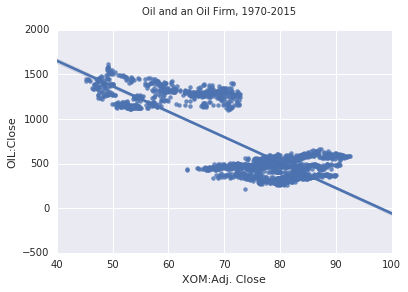

In [9]:
fig, ax = plt.subplots()
splot = sns.regplot("XOM:Adj. Close","OIL:Close",data=renamed_data, ax=ax)
fig.suptitle('Oil and an Oil Firm, 1970-2015')